# **Credit Limit** Prediction Using Deep Neural Networks

## Authors
- **Kianoosh Vadaei**: Researcher
- **Melika Shirian**: Researcher

### Contact Information
- Kianoosh Vadaei: [email](mailto:kia.vadaei@gmail.com), [LinkedIn](https://www.linkedin.com/in/kianoosh-vadaei-0aa58611b/), [GitHub](https://github.com/kia-vadaei)
- Melika Shirian: [email](mel.shirian@gmail.com), [LinkedIn](https://www.linkedin.com/in/melika-shirian-b8477a254/), [GitHub](https://github.com/MelikaShirian12)


## Introduction
This notebook provides an analysis of **Credit Limit** Prediction. We will cover the following steps:
1. Data Loading
2. Data Preprocessing
3. Exploratory Data Analysis
4. Model Building
5. Model Evaluation
6. Conclusion

## Table of Contents
1. [Introduction](#Introduction)
2. [Data Loading](#Data-Loading)
3. [Data Preprocessing](#Data-Preprocessing)
4. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
5. [Model Building](#Model-Building)
6. [Model Evaluation](#Model-Evaluation)
7. [Conclusion](#Conclusion)



In [1]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import ReduceLROnPlateau, MultiplicativeLR
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import PCA
from tqdm import *
import seaborn as sns
import time

<a id='Data-Loading'></a>
## **Data Loading**
In this section, we will load the dataset and display the first few rows to understand its structure.


In [2]:
data_df = pd.read_csv('../data/CreditPrediction.csv')
# removing duplicated datas
data_no_dup = data_df.drop_duplicates() 
# data_no_dup = data_no_dup.fillna(0)
# data_no_dup = pd.get_dummies(data_no_dup, columns=['Gender', 'Education_Level', 'Marital_Status', 'Income_Category', 'Card_Category'], drop_first=True, )


# data_no_dup.fillna(0, inplace=True)
data_no_dup

,CLIENTNUM,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Unnamed: 19
0,768805383,45.0,M,3,High School,Married,$60K - $80K,Blue,39.0,5.0,1,3,12691.0,777,1.335,1144,42,1.625,0.061,NaN
1,818770008,49.0,F,5,Graduate,NaN,Less than $40K,Blue,44.0,6.0,1,2,8256.0,864,1.541,1291,33,3.714,0.105,NaN
2,713982108,51.0,M,3,Graduate,Married,$80K - $120K,Blue,36.0,4.0,1,0,3418.0,0,2.594,1887,20,2.333,0.000,NaN
3,769911858,40.0,F,4,High School,NaN,Less than $40K,Blue,34.0,3.0,4,1,3313.0,2517,1.405,1171,20,2.333,0.760,NaN
4,709106358,40.0,M,3,Uneducated,Married,$60K - $80K,NaN,21.0,5.0,1,0,4716.0,0,2.175,816,28,2.500,0.000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10128,712110333,37.0,F,3,High School,NaN,Unknown,NaN,18.0,4.0,1,3,2179.0,0,0.725,2568,48,0.297,0.000,NaN
10134,712674183,53.0,M,2,College,NaN,$40K - $60K,Blue,33.0,3.0,3,1,4065.0,2180,0.321,1271,36,0.200,0.536,NaN
10135,718421808,56.0,F,2,Uneducated,Married,Unknown,Blue,43.0,6.0,3,2,3068.0,1765,0.853,4611,73,0.698,0.575,NaN
10136,809452383,37.0,F,2,Graduate,Married,Less than $40K,NaN,32.0,6.0,1,3,1438.3,0,0.707,4733,89,0.816,0.000,NaN


count    9911.000000
mean       35.915347
std         7.983965
min        13.000000
25%        31.000000
50%        36.000000
75%        40.000000
max        56.000000
Name: Months_on_book, dtype: float64

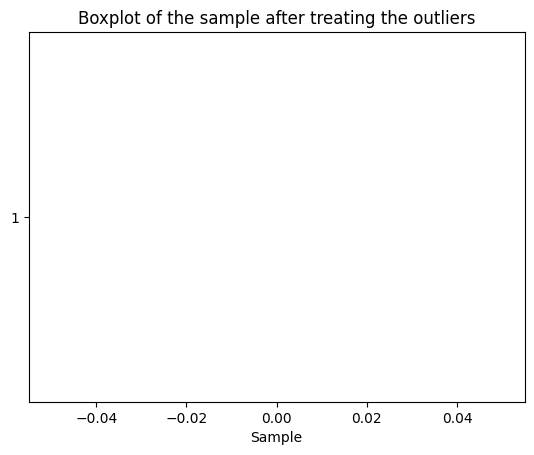

In [3]:
a = data_no_dup['Months_on_book']
plt.boxplot(a, vert=False)
plt.title("Boxplot of the sample after treating the outliers")
plt.xlabel("Sample")
data_no_dup['Months_on_book'].describe()

In [4]:
# plt.boxplot(data_no_dup['Credit_Limit'], vert=False)
# plt.title("Boxplot of the sample after treating the outliers")
# plt.xlabel("Sample")
# a= data_no_dup[data_no_dup['Credit_Limit']>20000]
# a.shape

# upper=data_no_dup['Credit_Limit'].quantile(0.005)
# lower=data_no_dup['Credit_Limit'].quantile(0.91)
# print(upper, lower)


## **Handling Outliers:**

In [5]:
def detect_outliers_iqr(data_col, is_taeget=False):

    outliers = []
    data_sorted = sorted(data_col)
    q1 = np.percentile(data_sorted, 25)
    q3 = np.percentile(data_sorted, 75)
    # print(q1, q3)
    IQR = q3-q1
    lwr_bound = q1-(1.5*IQR)
    upr_bound = q3+(1.5*IQR)
    if is_taeget:
        lwr_bound = q1
        upr_bound = q3
        
    inbox_indcs = (data_sorted >= lwr_bound) & (data_sorted <= upr_bound)
    inbox_data = data_col[inbox_indcs]
    inbox_media = np.median(inbox_data)

    # print(lwr_bound, upr_bound)
    for d in data_sorted: 
        if (d<lwr_bound or d>upr_bound):
            index = data_col.loc[data_col == d].index
            for i in index:
                data_col[i] = inbox_media
            outliers.append(i)
    return outliers# Driver code

def fix_outliers(data, is_taeget=False):
    if is_taeget:
        outliers = detect_outliers_iqr(data, is_taeget=True)
        print(f"Fixed {len(outliers)} outliers in target column")
        return data
    else:
        for col in data.columns:
            if data[col].dtype != 'object':
                outliers = detect_outliers_iqr(data[col])
                print(f"Fixed {len(outliers)} outliers in {col} column")
        return data

## **Done Outliers:**

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

1.6673134968834804
(10132, 20)


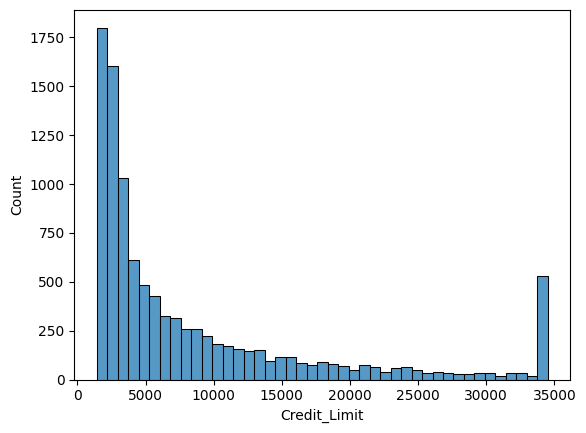

(5062, 20)
0.7611011569253084


/tmp/ipykernel_91105/1159606868.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_no_dup.drop(index,inplace=True)


(5062, 20)

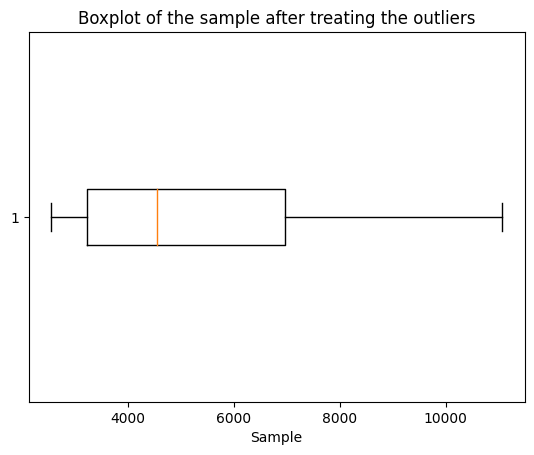

In [7]:
print(data_no_dup['Credit_Limit'].skew())
print(data_no_dup.shape)
sns.histplot(data=data_no_dup,x="Credit_Limit")
plt.show()

upper=data_no_dup['Credit_Limit'].quantile(0.25)
lower=data_no_dup['Credit_Limit'].quantile(0.75)

#print(upper,lower)

index=data_no_dup[(data_no_dup['Credit_Limit']>=lower)|(data_no_dup['Credit_Limit']<=upper)].index

data_no_dup.drop(index,inplace=True)
print(data_no_dup.shape)

data_no_dup['Credit_Limit'].describe()
print(data_no_dup['Credit_Limit'].skew())
plt.boxplot(data_no_dup['Credit_Limit'], vert=False)
plt.title("Boxplot of the sample after treating the outliers")
plt.xlabel("Sample")

data_no_dup.shape


In [8]:
def fix_missing_values(df):
    # Identify numerical and categorical columns
    num_cols = df.select_dtypes(exclude='object').columns
    cat_cols = df.select_dtypes(include='object').columns

    # Create transformers for numerical and categorical data
    num_transformer = IterativeImputer()
    cat_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ])

    # Combine transformers into a ColumnTransformer
    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_transformer, num_cols),
            ('cat', cat_transformer, cat_cols)
        ]
    )

    # Apply the transformations
    preprocessed_data = preprocessor.fit_transform(data_no_dup)

    # Convert the result back to a DataFrame (optional)
    preprocessed_df = pd.DataFrame(preprocessed_data)

    # Display the preprocessed DataFrame
    return preprocessed_df

/home/kianoosh/anaconda3/envs/pytorch/lib/python3.11/site-packages/sklearn/impute/_base.py:577: UserWarning: Skipping features without any observed values: [13]. At least one non-missing value is needed for imputation with strategy='mean'.
  warnings.warn(


Fixed 0 outliers in 0 column
Fixed 12 outliers in 1 column
Fixed 0 outliers in 2 column
Fixed 338 outliers in 3 column
Fixed 0 outliers in 4 column
Fixed 164 outliers in 5 column
Fixed 328 outliers in 6 column
Fixed 0 outliers in 7 column
Fixed 188 outliers in 8 column
Fixed 461 outliers in 9 column
Fixed 0 outliers in 10 column
Fixed 213 outliers in 11 column
Fixed 0 outliers in 12 column
Fixed 0 outliers in 13 column
Fixed 0 outliers in 14 column
Fixed 508 outliers in 15 column
Fixed 227 outliers in 16 column
Fixed 0 outliers in 17 column
Fixed 1035 outliers in 18 column
Fixed 256 outliers in 19 column
Fixed 698 outliers in 20 column
Fixed 755 outliers in 21 column
Fixed 278 outliers in 22 column
Fixed 0 outliers in 23 column
Fixed 0 outliers in 24 column
Fixed 308 outliers in 25 column
Fixed 219 outliers in 26 column
Fixed 1071 outliers in 27 column
Fixed 692 outliers in 28 column
Fixed 549 outliers in 29 column
Fixed 0 outliers in 30 column
Fixed 601 outliers in 31 column
Fixed 36 

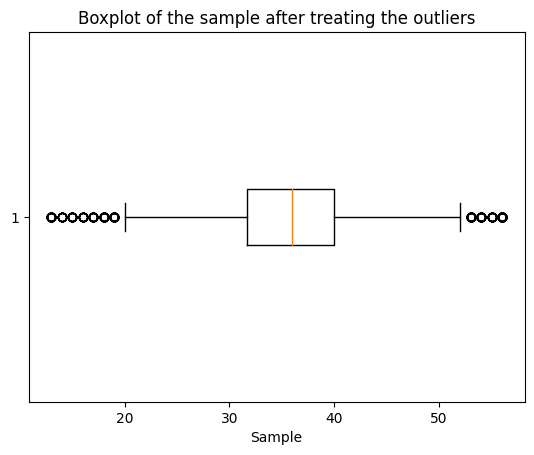

In [9]:
X = data_no_dup.drop('Credit_Limit', axis=1)
y = data_no_dup['Credit_Limit']

X = fix_missing_values(X)
plt.boxplot(X[3], vert=False)
plt.title("Boxplot of the sample after treating the outliers")
plt.xlabel("Sample")
X = fix_outliers(X)
# y = fix_outliers(y, is_taeget=True)



,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
0,818770008.0,49.0,5.0,44.0,6.0,1.0,2.0,864.0,0.734,1291.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
1,713982108.0,51.0,3.0,36.0,4.0,1.0,3.0,0.0,0.734,1887.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,769911858.0,40.0,4.0,34.0,3.0,4.0,1.0,2517.0,0.734,1171.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
3,709106358.0,40.0,3.0,21.0,5.0,1.0,3.0,0.0,0.734,816.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,713061558.0,44.0,2.0,36.0,3.0,1.0,2.0,1247.0,0.734,1088.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5057,717406983.0,30.0,2.0,36.0,4.0,3.0,3.0,0.0,0.535,8395.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5058,714337233.0,43.0,2.0,25.0,6.0,2.0,4.0,1961.0,0.703,3578.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
5059,712674183.0,53.0,2.0,33.0,3.0,3.0,1.0,2180.0,0.321,1271.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
5060,718421808.0,56.0,2.0,43.0,6.0,3.0,2.0,1765.0,0.853,4611.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


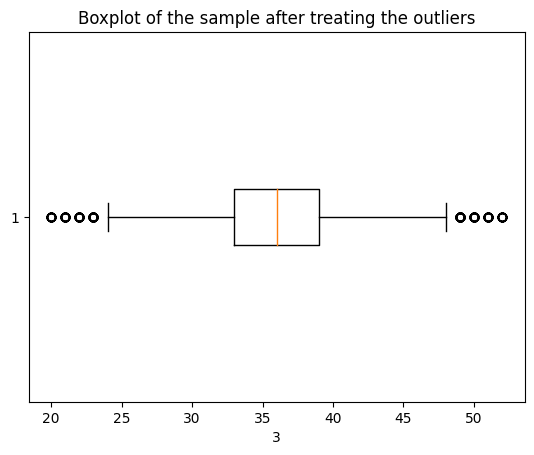

In [10]:
i = 3
plt.boxplot(X[i], vert=False)
plt.title("Boxplot of the sample after treating the outliers")
plt.xlabel(i)
X

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=45)
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

pca = PCA(25)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)
X_train_pca.shape

(3391, 25)

In [12]:
def select_features(X_train, y_train, X_test):
 fs = SelectKBest(score_func=mutual_info_regression, k=X_train_pca.shape[1] - 8)
 fs.fit(X_train, y_train)
 X_train_fs = fs.transform(X_train)

 X_test_fs = fs.transform(X_test)
 return X_train_fs, X_test_fs, fs


In [13]:

X_train_fs, X_test_fs, fs = select_features(X_train_pca, y_train, X_test_pca)

Feature 0: 0.050343
Feature 1: 0.028968
Feature 2: 0.034958
Feature 3: 0.004455
Feature 4: 0.015635
Feature 5: 0.000000
Feature 6: 0.000000
Feature 7: 0.003229
Feature 8: 0.000000
Feature 9: 0.000000
Feature 10: 0.000000
Feature 11: 0.000000
Feature 12: 0.006418
Feature 13: 0.040387
Feature 14: 0.018427
Feature 15: 0.035282
Feature 16: 0.090627
Feature 17: 0.555181
Feature 18: 0.001083
Feature 19: 0.000000
Feature 20: 0.000914
Feature 21: 0.000000
Feature 22: 0.000000
Feature 23: 0.000000
Feature 24: 0.000000
13


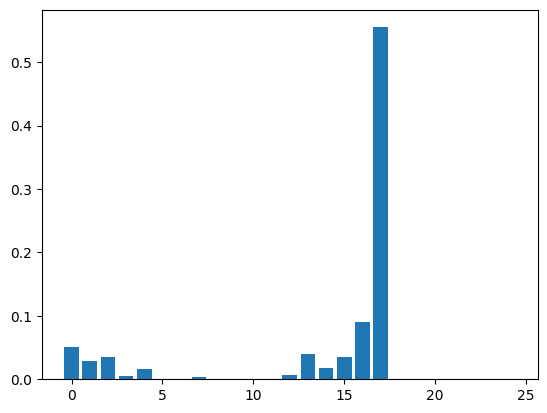

In [14]:
# what are scores for the features
ignr_cnt = 0
for i in range(len(fs.scores_)):
 if (fs.scores_[i] < 0.0015):
  ignr_cnt +=1
 print('Feature %d: %f' % (i, fs.scores_[i]))
print(ignr_cnt)
# plot the scores
plt.bar([i for i in range(len(fs.scores_))], fs.scores_)
plt.show()

In [15]:
X_train_fs = np.array(X_train_fs) 
X_test_fs = np.array(X_test_fs) 

y_train = np.array(y_train) 
y_test = np.array(y_test) 



In [16]:
X_train_fs = torch.from_numpy(X_train_fs.astype(np.float32))
X_test_fs = torch.from_numpy(X_test_fs.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

X_train = torch.from_numpy(X_train.astype(np.float32))


y_train = y_train.view(y_train.shape[0], 1)
y_test = y_test.view(y_test.shape[0], 1)

X_test = torch.from_numpy(X_test.astype(np.float32))

_, n_features = X_train_fs.shape




In [17]:
X_train_fs  = X_train_fs.to(device)
y_train = y_train.to(device)
X_train = X_train.to(device)

X_test_fs  = X_test_fs.to(device)
y_test = y_test.to(device)

X_test = X_test.to(device)


In [18]:
class BankDataset(Dataset):
    def __init__(self, data, targets):
        self.data = data
        self.targets = targets
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        sample = (self.data[idx], self.targets[idx])
        return sample

In [19]:
dataset = BankDataset(X_train_fs, y_train)
dataloader = DataLoader(dataset=dataset, batch_size=64, shuffle=True)


In [20]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Model, self).__init__()
        self.dropout = nn.Dropout(0.2)
        self.linear1 = nn.Linear(input_size, hidden_size)
        self.leaky_reLu = nn.LeakyReLU()
        self.reLu = nn.ReLU()

        self.linear2 = nn.Linear(hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        out = self.dropout(x)

        out = self.linear1(out)
        out = self.leaky_reLu(out)
        out = self.linear2(out)
        # out = self.sigmoid(out)
        return out

In [21]:
class Model2(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(Model2, self).__init__()
        self.dropout = nn.Dropout(0.05)
        self.linear1 = nn.Linear(input_size, hidden_size)

        
        self.linear2 = nn.Linear(hidden_size, int(hidden_size/2))
        self.linear3 = nn.Linear(int(hidden_size/2), 1)
        # self.linear4 = nn.Linear(12, 1)


        self.leaky_reLu = nn.LeakyReLU()
        self.reLu = nn.ReLU()

        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        out = self.dropout(x)
        out = self.linear1(out)
        out = self.leaky_reLu(out)
        out = self.linear2(out)
        out = self.leaky_reLu(out)
        out = self.linear3(out)
        # out = self.leaky_reLu(out)
        # out = self.linear4(out)
        # out = self.sigmoid(out)
        return out

In [22]:
model = Model2(n_features , 16)
model = model.to(device)

n_features

17

In [23]:
num_epochs = 300000
learning_rate = 0.001
list_of_losses = []
list_of_losses_test = []
criterion = nn.MSELoss()  ####################################################################
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lmbda = lambda epoch: 0.95

scheduler = MultiplicativeLR(optimizer, lr_lambda=lmbda)
lambda_reg = 0.01
loss = 0



for epoch in range(num_epochs):
    # Forward pass and loss
    # model.zero_grad()
    y_pred = model(X_train_fs)
    loss = criterion(y_pred, y_train)

    # TODO Validation
    # TODO Bath
    # TODO 2 for

    # # Compute L2 regularization term
    l2_reg = torch.tensor(0.)
    l2_reg = l2_reg.to(device)

    for param in model.parameters():
        l2_reg += torch.norm(param)
    
    # Add regularization term to loss
    loss += lambda_reg * l2_reg

    # Backward pass and update

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    # zero grad before new step

    if (epoch+1) % 1000 == 0:
        print(f"epoch: {epoch+1}, loss = {loss.item():.4f} || "
              f"lr: {optimizer.state_dict()['param_groups'][0]['lr']:.7f}")
        list_of_losses.append(loss.item())
        list_of_losses_test.append(criterion(model(X_test_fs), y_test).item())
    if (epoch+1) % 5000 == 0 and epoch > 5000:
        scheduler.step()
    



epoch: 1000, loss = 22174840.0000 || lr: 0.0010000
epoch: 2000, loss = 4259591.0000 || lr: 0.0010000
epoch: 3000, loss = 2735504.5000 || lr: 0.0010000
epoch: 4000, loss = 2214036.2500 || lr: 0.0010000
epoch: 5000, loss = 2048006.3750 || lr: 0.0010000
epoch: 6000, loss = 1969606.1250 || lr: 0.0010000
epoch: 7000, loss = 1910231.0000 || lr: 0.0010000
epoch: 8000, loss = 1853508.5000 || lr: 0.0010000
epoch: 9000, loss = 1792601.7500 || lr: 0.0010000
epoch: 10000, loss = 1815797.6250 || lr: 0.0010000
epoch: 11000, loss = 1734546.1250 || lr: 0.0009500
epoch: 12000, loss = 1799167.2500 || lr: 0.0009500
epoch: 13000, loss = 1787035.3750 || lr: 0.0009500
epoch: 14000, loss = 1728229.2500 || lr: 0.0009500
epoch: 15000, loss = 1831070.7500 || lr: 0.0009500
epoch: 16000, loss = 1805065.2500 || lr: 0.0009025
epoch: 17000, loss = 1748842.3750 || lr: 0.0009025
epoch: 18000, loss = 1719577.2500 || lr: 0.0009025
epoch: 19000, loss = 1677587.2500 || lr: 0.0009025
epoch: 20000, loss = 1718461.5000 || lr

KeyboardInterrupt: 

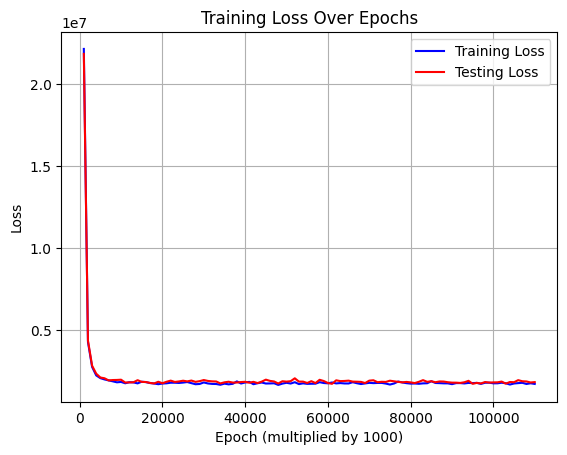

In [24]:
epochs = [epoch * 1000 for epoch in range(1, len(list_of_losses) + 1)]

# Plot the losses
plt.plot(epochs, list_of_losses, linestyle='-', color='b', label='Training Loss')
plt.plot(epochs, list_of_losses_test, linestyle='-', color='r', label='Testing Loss')

# Add title and labels
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch (multiplied by 1000)')
plt.ylabel('Loss')

# Add grid
plt.grid(True)

# Add legend
plt.legend()

# Display the plot
plt.show()


In [29]:
from sklearn.metrics import mean_squared_error
with torch.no_grad():
    y_predicted = model(X_test_fs)
    # y_predicted = np.array(y_predicted)
     
    MSE = mean_squared_error(y_predicted.cpu(), y_test.cpu())
MSE

1796105.4

In [31]:
#random forest
X_train_fs = X_test_fs.to('cpu')
y_train = y_test.to('cpu')
X_test_fs = X_test_fs.to('cpu')
y_test = y_test.to('cpu')


X_test_fs = X_test_fs.numpy()
X_train_fs = X_train_fs.numpy()
y_test = y_test.numpy().flatten()
y_train = y_train.numpy().flatten()


In [32]:
y_train.shape

(1671,)

In [33]:

# Import libraries
import pandas as pd
from pycaret.regression import *
s = setup(data = X_train_fs, target = y_train, session_id=123)
best = compare_models()
evaluate_model(best)
predict_holdout = predict_model(X_test_fs)

,Description,Value
0,Session id,123
1,Target,target
2,Target type,Regression
3,Original data shape,"(1671, 18)"
4,Transformed data shape,"(1671, 18)"
5,Transformed train set shape,"(1169, 18)"
6,Transformed test set shape,"(502, 18)"
7,Numeric features,17
8,Preprocess,True
9,Imputation type,simple


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
gbr,Gradient Boosting Regressor,991.2974,1909855.8374,1374.4037,0.6436,0.2404,0.1923,0.0520
lightgbm,Light Gradient Boosting Machine,923.0064,1905038.6010,1372.2331,0.6435,0.2391,0.1765,1.6200
rf,Random Forest Regressor,952.4820,1963189.5281,1392.0056,0.6340,0.2369,0.1764,0.0730
et,Extra Trees Regressor,944.4852,1965715.6232,1392.5279,0.6338,0.2364,0.1753,0.0320
ridge,Ridge Regression,1094.4852,1970381.7750,1398.6728,0.6302,0.3035,0.2291,0.0050
lasso,Lasso Regression,1094.6931,1970184.8875,1398.5815,0.6302,0.3043,0.2292,0.0050
llar,Lasso Least Angle Regression,1094.6930,1970185.1750,1398.5815,0.6302,0.3043,0.2292,0.0060
lar,Least Angle Regression,1095.3018,1970387.6875,1398.6417,0.6302,0.3054,0.2295,0.0050
lr,Linear Regression,1095.3017,1970387.5500,1398.6417,0.6302,0.3054,0.2295,0.0060
br,Bayesian Ridge,1094.0707,1970512.5000,1398.7345,0.6302,0.3025,0.2289,0.0110


interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

AttributeError: 'numpy.ndarray' object has no attribute 'predict'